In [ ]:
##Design a simple neural network with a Batch Normalization layer in the hidden layers, and another without Batch Normalization in the hidden layers.
 Then, plot a contour plot to visualize the loss landscape during training

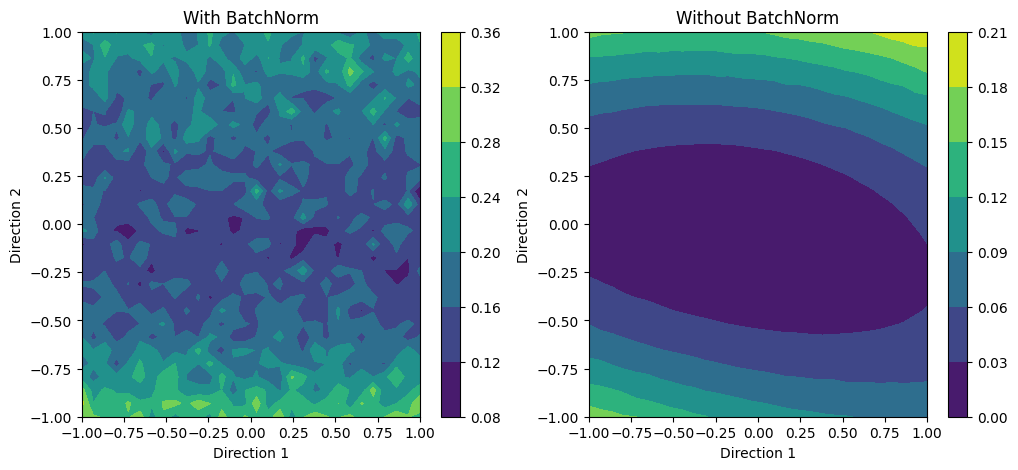

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Define neural networks
class NetWithBN(nn.Module):
    def __init__(self):
        super(NetWithBN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

class NetWithoutBN(nn.Module):
    def __init__(self):
        super(NetWithoutBN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Generate synthetic dataset
torch.manual_seed(42)
x_data = torch.randn(500, 2)
y_data = (x_data[:, 0] * x_data[:, 1]).unsqueeze(1)  # Simple nonlinear function
dataset = TensorDataset(x_data, y_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train function
def train(model, dataloader, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            loss = criterion(model(x_batch), y_batch)
            loss.backward()
            optimizer.step()
    return model

# Train both models
model_bn = train(NetWithBN(), dataloader)
model_no_bn = train(NetWithoutBN(), dataloader)

# Function to compute loss landscape
def compute_loss_landscape(model, dataloader, perturb_range=(-1, 1), steps=30):
    params = list(model.parameters())
    p1 = params[0].detach().clone()
    p2 = params[1].detach().clone()
    u = torch.randn_like(p1)
    v = torch.randn_like(p2)
    u /= torch.norm(u)
    v /= torch.norm(v)

    loss_values = np.zeros((steps, steps))
    for i, alpha in enumerate(np.linspace(*perturb_range, steps)):
        for j, beta in enumerate(np.linspace(*perturb_range, steps)):
            with torch.no_grad():
                params[0].copy_(p1 + alpha * u)
                params[1].copy_(p2 + beta * v)
            loss = sum(nn.MSELoss()(model(xb), yb).item() for xb, yb in dataloader) / len(dataloader)
            loss_values[i, j] = loss

    return loss_values





# Compute loss landscapes
loss_bn = compute_loss_landscape(model_bn, dataloader)
loss_no_bn = compute_loss_landscape(model_no_bn, dataloader)

# Plot contour maps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, loss, title in zip(axes, [loss_bn, loss_no_bn], ['With BatchNorm', 'Without BatchNorm']):
    cs = ax.contourf(np.linspace(-1, 1, 30), np.linspace(-1, 1, 30), loss, cmap='viridis')
    fig.colorbar(cs, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Direction 1')
    ax.set_ylabel('Direction 2')

plt.show()
